In [ ]:
import os
os.chdir('/content/drive/MyDrive/RDRO_Simul/Portfolio Optimization')

import portfolio_Opt as po
import numpy as np
import pickle
import concurrent.futures
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle


In [ ]:
import Regret_Analysis_Finite as ra
import L2_regularization as l2
import numpy as np

# L_2 regularization


In [20]:

# Generate true distribution
random.seed(10)
e_0, p_0 = ra.get_true_dist(N=50)

# Generate perturbed distributions
Qs = ra.get_Qs(e_0, M=5, eta=0.1)

# Calculate regrets for a list of decisions
decisions = [np.array([0.3, 0.4, 0.3]), np.array([0.2, 0.5, 0.3])]
regrets = ra.get_regrets(decisions, Qs, e_0)

regrets


,x0,x1
0,0.091173,0.067661
1,0.093724,0.068607
2,0.086592,0.061465
3,0.098287,0.071581
4,0.097089,0.070806


# Sanity check 1

Without data,
$(x_{\lambda} - x^*)/\lambda \approx  v_0$

<Axes: >

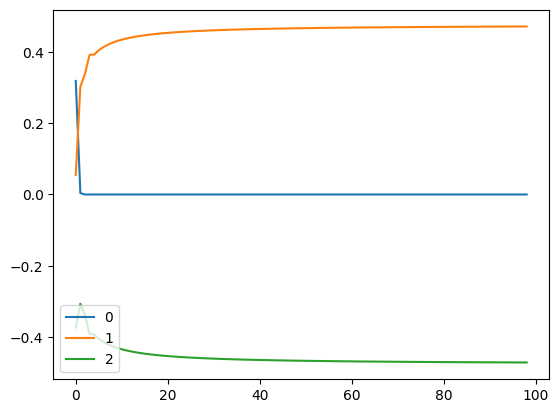

In [21]:
Ls = 1/(np.array(range(1,100))*4)
xs = [l2.L_2_optimize(e_0,l) for l in Ls]

x_star = ra.EO_solution(e_0)
A = np.array([(xs[i]-x_star)/Ls[i] for i in range(len(xs))])
A = pd.DataFrame(A)
A.plot()

# Sanity check 2

Without data,
$R(x_{\lambda},P)/\lambda^2 \approx  c$

<Axes: >

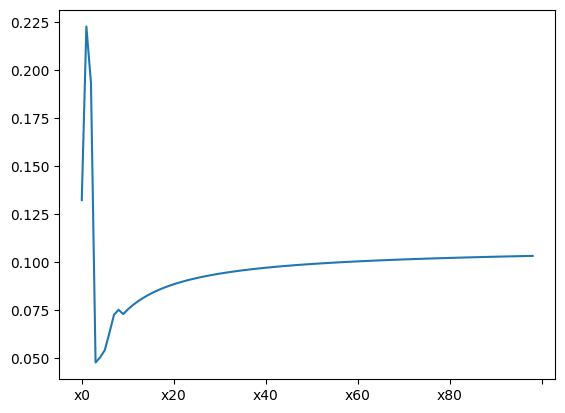

In [22]:
Ls = 1/(np.array(range(1,100))*2)
xs = [l2.L_2_optimize(e_0,l) for l in Ls]
A = ra.get_regrets(xs,[p_0],e_0)/(Ls**2)
A.loc[0].plot()

# Simulation

Load the pickle files (from insomnia)

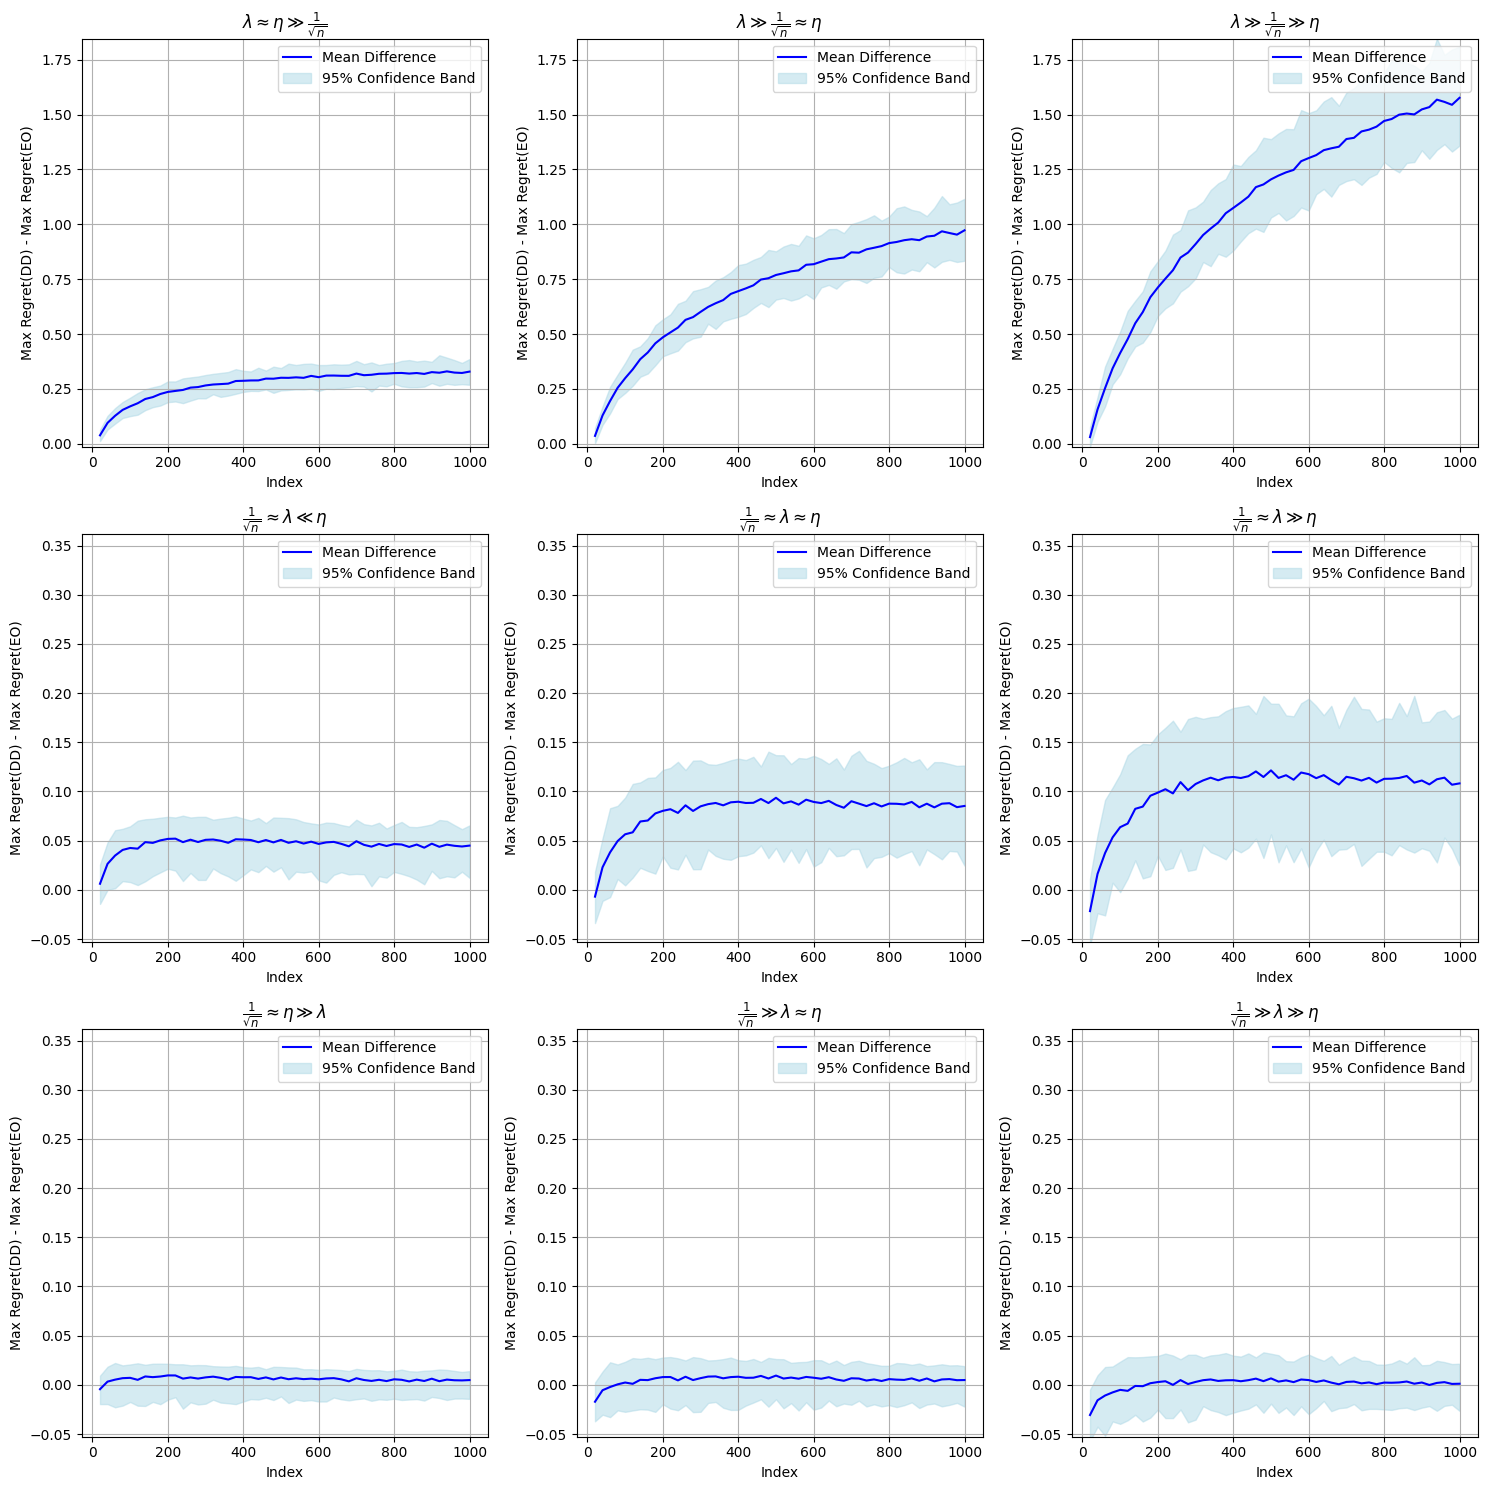

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary containing simulation parameters
sim_params = {
    "simulation_1": [0.5, 0.3, 0.5, 0.3, r'$\lambda \approx \eta \gg \frac{1}{\sqrt{n}}$'],  # Large λ Large η
    "simulation_2": [0.5, 0.3, 0.5, 0.5, r'$\lambda \gg \frac{1}{\sqrt{n}} \approx \eta$'],  # Large λ Equal η
    "simulation_3": [0.5, 0.3, 0.5, 0.7, r'$\lambda \gg \frac{1}{\sqrt{n}} \gg \eta$'],      # Large λ Small η
    "simulation_4": [0.5, 0.5, 0.5, 0.3, r'$\frac{1}{\sqrt{n}} \approx \lambda \ll \eta$'],  # Equal λ Large η
    "simulation_5": [0.5, 0.5, 0.5, 0.5, r'$\frac{1}{\sqrt{n}} \approx \lambda \approx \eta$'],  # Equal λ Equal η
    "simulation_6": [0.5, 0.5, 0.5, 0.7, r'$\frac{1}{\sqrt{n}} \approx \lambda \gg \eta$'],  # Equal λ Small η
    "simulation_7": [0.5, 0.7, 0.5, 0.3, r'$\frac{1}{\sqrt{n}} \approx \eta \gg \lambda $'],  # Small λ Large η
    "simulation_8": [0.5, 0.7, 0.5, 0.5, r'$\frac{1}{\sqrt{n}} \gg \lambda \approx \eta$'],  # Small λ Equal η
    "simulation_9": [0.5, 0.7, 0.5, 0.7, r'$\frac{1}{\sqrt{n}} \gg \lambda \gg \eta$'],  # Small λ Small η
}

# Function to calculate the min and max y-limits for a given set of simulations
def calculate_row_limits(filenames):
    row_min, row_max = float('inf'), float('-inf')

    for filename in filenames:
        with open(filename, 'rb') as f:
            data = pickle.load(f)

        data = data[1:]  # Ignore the parameters

        # Calculate the difference DRO - EO for each dataframe
        differences = [df['DD'] - df['EO'] for df in data]
        differences_df = pd.DataFrame(differences).T

        # Calculate the mean difference and confidence intervals
        mean_diff = differences_df.mean(axis=1)
        ci_lower = differences_df.quantile(0.025, axis=1)
        ci_upper = differences_df.quantile(0.975, axis=1)

        # Update row min and max values
        row_min = min(row_min, ci_lower.min(), mean_diff.min(), ci_upper.min())
        row_max = max(row_max, ci_lower.max(), mean_diff.max(), ci_upper.max())

    return row_min, row_max

# Plot function with specific y-limits
def plotCI(filename, ax, title, y_min, y_max):
    # Load the data from the pickle file
    with open(filename, 'rb') as f:
        data = pickle.load(f)

    params = data[0]
    data = data[1:]

    # Calculate the difference DRO - EO for each dataframe
    differences = [df['DD'] - df['EO'] for df in data]
    differences_df = pd.DataFrame(differences).T

    # Compute mean and confidence intervals
    mean_diff = differences_df.mean(axis=1)
    ci_lower = differences_df.quantile(0.025, axis=1)
    ci_upper = differences_df.quantile(0.975, axis=1)

    # Plot the mean difference with the confidence band
    indices = differences_df.index
    ax.plot(indices, mean_diff, label='Mean Difference', color='blue')
    ax.fill_between(indices, ci_lower, ci_upper, color='lightblue', alpha=0.5, label='95% Confidence Band')

    ax.set_title(title)
    ax.set_xlabel('Index')
    ax.set_ylabel('Max Regret(DD) - Max Regret(EO)')
    ax.legend()
    ax.grid(True)

    # Set the y-limits for the plot
    ax.set_ylim([y_min, y_max])

# Create a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# List of simulation file names
filenames = [
    'pickles/L_2/simulation_1.pkl',
    'pickles/L_2/simulation_2.pkl',
    'pickles/L_2/simulation_3.pkl',
    'pickles/L_2/simulation_4.pkl',
    'pickles/L_2/simulation_5.pkl',
    'pickles/L_2/simulation_6.pkl',
    'pickles/L_2/simulation_7.pkl',
    'pickles/L_2/simulation_8.pkl',
    'pickles/L_2/simulation_9.pkl'
]

# Calculate y-limits for the first row (simulations 1, 2, 3)
row_1_min, row_1_max = calculate_row_limits(filenames[:3])

# Calculate y-limits for the second and third rows (simulations 4-9)
row_2_3_min, row_2_3_max = calculate_row_limits(filenames[3:])
row_2_3_min = row_2_3_min*0.9 + row_1_min*0.1
row_2_3_max = row_2_3_max*0.9 + row_1_max*0.1
# Plot the first row with its specific y-limits
for i in range(3):
    sim_name = f'simulation_{i+1}'
    title = sim_params[sim_name][4]
    plotCI(filenames[i], axes[0, i], title, row_1_min, row_1_max)

# Plot the second and third rows with their y-limits
for i in range(3, 9):
    sim_name = f'simulation_{i+1}'
    title = sim_params[sim_name][4]
    row_idx = (i - 3) // 3 + 1  # Row index for axes
    col_idx = (i - 3) % 3  # Column index for axes
    plotCI(filenames[i], axes[row_idx, col_idx], title, row_2_3_min, row_2_3_max)

# Adjust layout
plt.tight_layout()
plt.show()


## KL-DRO

In [29]:
import DRO as dro

def data_driven(samples, lambda_):
  return dro.dro_solution(samples, lambda_**2, dro.phi_star_KL)

## Sanity Check 1

<Axes: >

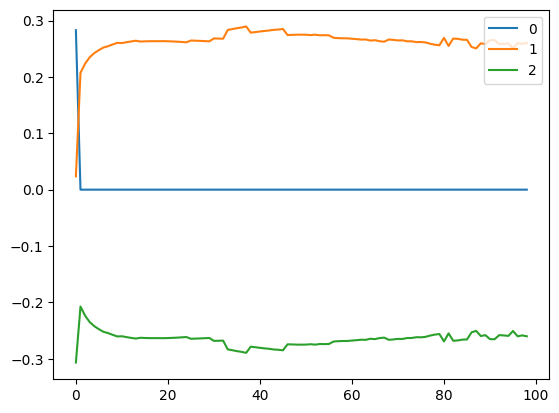

In [30]:
Ls = 1/(np.array(range(1,100))*4)
xs = [data_driven(e_0,l) for l in Ls]

x_star = ra.EO_solution(e_0)
A = np.array([(xs[i]-x_star)/Ls[i] for i in range(len(xs))])
A = pd.DataFrame(A)
A.plot()

## Sanity Check 2

<Axes: >

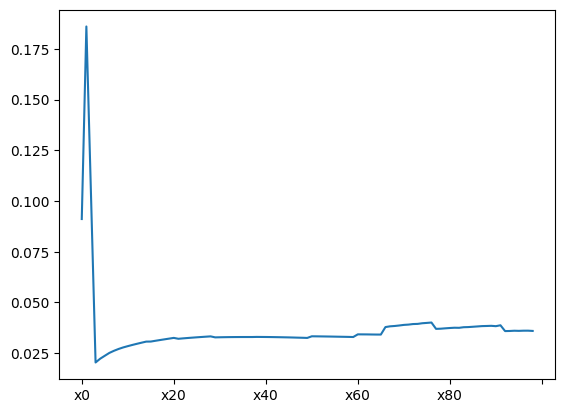

In [31]:
Ls = 1/(np.array(range(1,100))*2)
xs = [data_driven(e_0,l) for l in Ls]
A = ra.get_regrets(xs,[p_0],e_0)/(Ls**2)
A.loc[0].plot()

In [14]:
import numpy as np
import pickle
import concurrent.futures
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import Regret_Analysis_Finite as ra
import L2_regularization as l2
import DRO as dro

import argparse


sim_params = {
    "simulation_1": [0.5, 0.3, 0.5, 0.3, 'Large lambda Large eta'],
    "simulation_2": [0.5, 0.3, 0.5, 0.5, 'Large lambda equal eta'],
    "simulation_3": [0.5, 0.3, 0.5, 0.7, 'Large lambda small eta'],
    "simulation_4": [0.5, 0.5, 0.5, 0.3, 'Equal lambda Large eta'],
    "simulation_5": [0.5, 0.5, 0.5, 0.5, 'Equal lambda Equal eta'],
    "simulation_6": [0.5, 0.5, 0.5, 0.7, 'Equal lambda Small eta'],
    "simulation_7": [0.5, 0.7, 0.5, 0.3, 'Small lambda Large eta'],
    "simulation_8": [0.5, 0.7, 0.5, 0.5, 'Small lambda equal eta'],
    "simulation_9": [0.5, 0.7, 0.5, 0.7, 'Small lambda Small eta'],
}

np.random.seed(10)
e_0, _ = ra.get_true_dist(50) # must be fixed for all simulations

name = "simulation_8"

##############################
#### Set Parameters ##########
##############################

destination = 'pickles/KL_DRO/'  # destination = 'pickles/L_2/'

N = 10 # repeats to get expectation. No. of times data is generated
M = 11 # repeats to get maximum (Number of distributions Q generated))

ns = np.array(range(1,5))*20

## function to get data driven solution
# data_driven = l2.L_2_optimize

def data_driven(samples, lambda_):
  return dro.dro_solution(samples, lambda_**2, dro.phi_star_KL)

##############################
##############################

G_l, K_l, G_e, K_e, comment = sim_params[name]

# Set File Name
name = destination + name + '.pkl'


simulation_params = {
    'comment': comment,
    'G_l': G_l,
    'K_l': K_l,
    'G_e': G_e,
    'K_e': K_e,
    'N': N,
    'M': M,
    'ns': ns.tolist()  # Convert numpy array to list for better readability in the dictionary
}



def run(i):
    np.random.seed(i)
    out = ra.Single_Run(ns, G_l, K_l, G_e, K_e, N, M, e_0, data_driven)
    return out

def run_simulations():
    # Get the number of available CPU cores
    n_cores = os.cpu_count()
    print(n_cores)
    # Set the number of  CPU cores to use
    n_cores = min(100,n_cores)
    # Create a list to hold the results from each simulation
    results = [simulation_params]

    # Create a ProcessPoolExecutor to run the simulations in parallel
    with concurrent.futures.ProcessPoolExecutor(max_workers=n_cores) as executor:
        # Submit the simulation function with inputs 1 to n_cores
        futures = [executor.submit(run, i) for i in range(1, n_cores + 1)]

        # Collect the results as they complete
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            results.append(result)

    # Save the entire list of results to a single pickle file
    with open(name, 'wb') as f:
        pickle.dump(results, f)

run_simulations()


2
20
20
40
40
60
60
8080

